In [1]:
import torch
import torch.nn as nn
import numpy as np
from func import seed_everything
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state
from torch.utils.data import DataLoader
import pandas as pd
import matplotlib.pyplot as plt
import model
from collections import defaultdict


In [2]:
SEED = 2010
RANDOM = check_random_state(SEED)
seed_everything(SEED)


SEED=2010


In [3]:
file1 = "../EXP/EXP_data/expression.csv"
exp1 = pd.read_csv(file1, sep="\t", index_col=0, header=0).T
scaler = StandardScaler()
scaled_exp1 = scaler.fit_transform(exp1.T)
X_train, X_test = train_test_split(
    scaled_exp1, test_size=0.9, shuffle=True, random_state=RANDOM
)
X_train, X_val = train_test_split(
    X_train, test_size=0.1, shuffle=True, random_state=RANDOM
)


In [4]:
def countZeroWeights(m):
    zeros = 0
    for param in m.parameters():
        if param is not None:
            zeros += torch.sum((param == 0).int()).item()
    return zeros


## train loop

In [5]:
def train(
    model, train_data, val_data, num_epochs=50, batch_size=32, learning_rate=0.001
):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    # Convert data to PyTorch tensors
    train_tensor = torch.Tensor(train_data).to(device)
    val_tensor = torch.Tensor(val_data).to(device)

    train_loader = DataLoader(train_tensor, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_tensor, batch_size=batch_size, shuffle=True)
    print("epoch\ttrain_loss\tval_loss")
    losses = defaultdict(list)
    for epoch in range(num_epochs):
        train_loss = torch.zeros(len(train_loader))
        for i, batch in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(batch)
            loss = criterion(outputs, batch)  # Reconstruction loss
            loss.backward()
            optimizer.step()

            train_loss[i] = loss
        train_loss_mean = train_loss.mean()

        if epoch % 10 == 0:
            with torch.no_grad():
                val_loss = torch.zeros(len(val_loader))
                model.eval()
                for i, batch in enumerate(val_loader):
                    outputs = model(batch)
                    loss = criterion(outputs, batch)
                    val_loss[i] = loss
                val_loss_mean = val_loss.mean()
                model.train()

            print(f"{epoch}\t{train_loss_mean.item():.4f}\t{val_loss_mean.item():.4f}")
            losses["train"].append(train_loss_mean.item())
            losses["val"].append(val_loss_mean.item())
    return model, losses


def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)  # Xavier initialization for weights
        nn.init.zeros_(m.bias)


## Training 

In [35]:
# models with ReLU
model6 = model.AE6(1343, 50)
model8 = model.AE8(1343, 50)

# models with LeakyReLU
model6_leaky = model.LeakyAE6(1343, 50)
model8_leaky = model.LeakyAE8(1343, 50)

# model with PReLU
model6_param = model.ParamAE6(1343, 50)
model8_param = model.ParamAE8(1343, 50)

models = [model6, model8, model6_leaky, model8_leaky, model6_param, model8_param]


### Training config: #1

In [10]:
%%time 
# training the models

train_models = []
train_val_losses = []
for m in models:
    print("next model")
    trained_model, losses = train(m, X_train, X_val, num_epochs=500)
    train_models.append(trained_model)
    train_val_losses.append(losses)


next model
epoch	train_loss	val_loss
0	0.2913	0.1671
10	0.0851	0.0914
20	0.0748	0.0677
30	0.0582	0.0605
40	0.0640	0.0637
50	0.0389	0.0584
60	0.0414	0.0570
70	0.0326	0.0584
80	0.0450	0.0585
90	0.0333	0.0582
100	0.0266	0.0588
110	0.0275	0.0611
120	0.0281	0.0653
130	0.0253	0.0575
140	0.0284	0.0649
150	0.0224	0.0561
160	0.0228	0.0563
170	0.0243	0.0577
180	0.0307	0.0662
190	0.0268	0.0591
200	0.0230	0.0592
210	0.0251	0.0599
220	0.0215	0.0570
230	0.0204	0.0584
240	0.0205	0.0585
250	0.0195	0.0572
260	0.0215	0.0591
270	0.0188	0.0580
280	0.0194	0.0576
290	0.0211	0.0582
300	0.0207	0.0589
310	0.0202	0.0599
320	0.0169	0.0572
330	0.0228	0.0586
340	0.0174	0.0578
350	0.0196	0.0619
360	0.0199	0.0596
370	0.0177	0.0588
380	0.0184	0.0591
390	0.0186	0.0599
400	0.0166	0.0577
410	0.0363	0.0733
420	0.0141	0.0569
430	0.0202	0.0604
440	0.0183	0.0585
450	0.0158	0.0584
460	0.0245	0.0611
470	0.0152	0.0608
480	0.0168	0.0604
490	0.0171	0.0588
next model
epoch	train_loss	val_loss
0	0.2973	0.2217
10	0.1249	0.1038
20	0

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, figsize=(18, 6), sharex=True)

ax1.plot(losses["train"])
ax1.set_ylabel("training loss")

ax2.plot(losses["val"])
ax2.set_ylabel("validation loss")

ax3.plot(losses["test"])
ax3.set_ylabel("test loss")

ax4.plot(losses["pca"])
ax4.set_ylabel("pca loss")

ax5.plot([x - y for x, y in zip(losses["test"], losses["pca"])])
ax5.set_ylabel("test - pca")


ax5.set_xlabel("epochs")


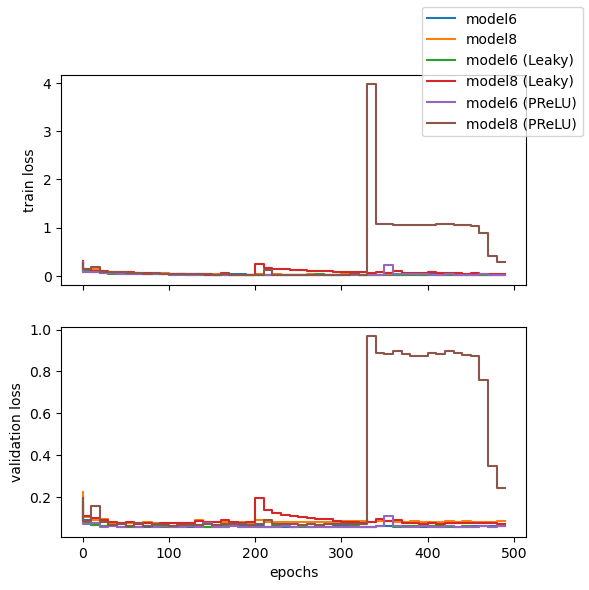

In [83]:
## Visualize the losses
xs = list(range(0, 500, 10))

fig, (ax1, ax2) = plt.subplots(2, figsize=(6, 6), sharex=True)

# model 6
ax1.step(xs, train_val_losses[0]["train"], label="model6")
ax2.step(xs, train_val_losses[0]["val"], label="model6")

# model 8
ax1.step(xs, train_val_losses[1]["train"], label="model8")
ax2.step(xs, train_val_losses[1]["val"], label="model8")


# model 6 LeakyReLU
ax1.step(xs, train_val_losses[2]["train"], label="model6 (Leaky)")
ax2.step(xs, train_val_losses[2]["val"], label="model6 (Leaky)")


# model 8 LeakyReLU
ax1.step(xs, train_val_losses[3]["train"], label="model8 (Leaky)")
ax2.step(xs, train_val_losses[3]["val"], label="model8 (Leaky)")


# model 6 PReLU
ax1.step(xs, train_val_losses[4]["train"], label="model6 (PReLU)")
ax2.step(xs, train_val_losses[4]["val"], label="model6 (PReLU)")


# model 8 PreLU
ax1.step(xs, train_val_losses[5]["train"], label="model8 (PReLU)")
ax2.step(xs, train_val_losses[5]["val"], label="model8 (PReLU)")

# ax1.set_ylim((0,0.2))
# ax2.set_ylim((0,0.2))
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")
ax1.set_ylabel("train loss")
ax2.set_ylabel("validation loss")
ax2.set_xlabel("epochs")

plt.savefig("lr1e-3.png", dpi=350)


### Training config: #2 (learning rate = 0.0001)

In [12]:
# training with a smaller learning rate

models_lrs = [model.apply(init_weights) for model in models]
train_models_lrs = []
train_val_losses_lrs = []
for i, m in enumerate(models_lrs):
    print(i, "--", "#" * 100)
    trained_model, losses = train(m, X_train, X_val, num_epochs=500, learning_rate=1e-4)
    train_models_lrs.append(trained_model)
    train_val_losses_lrs.append(losses)


0 -- ####################################################################################################
epoch	train_loss	val_loss
0	0.4593	0.1825
10	0.0759	0.0656
20	0.0547	0.0511
30	0.0469	0.0463
40	0.0406	0.0423
50	0.0363	0.0406
60	0.0331	0.0377
70	0.0318	0.0377
80	0.0286	0.0360
90	0.0288	0.0349
100	0.0259	0.0344
110	0.0244	0.0343
120	0.0249	0.0329
130	0.0225	0.0327
140	0.0241	0.0325
150	0.0211	0.0315
160	0.0207	0.0321
170	0.0205	0.0320
180	0.0197	0.0317
190	0.0189	0.0312
200	0.0187	0.0311
210	0.0199	0.0309
220	0.0176	0.0309
230	0.0169	0.0310
240	0.0175	0.0307
250	0.0167	0.0318
260	0.0160	0.0308
270	0.0159	0.0307
280	0.0157	0.0305
290	0.0158	0.0315
300	0.0151	0.0303
310	0.0151	0.0309
320	0.0148	0.0307
330	0.0143	0.0309
340	0.0141	0.0305
350	0.0152	0.0311
360	0.0149	0.0311
370	0.0141	0.0309
380	0.0135	0.0314
390	0.0138	0.0317
400	0.0136	0.0321
410	0.0137	0.0315
420	0.0129	0.0312
430	0.0122	0.0307
440	0.0122	0.0308
450	0.0123	0.0309
460	0.0120	0.0307
470	0.0122	0.0317
480	0.0115	0.03

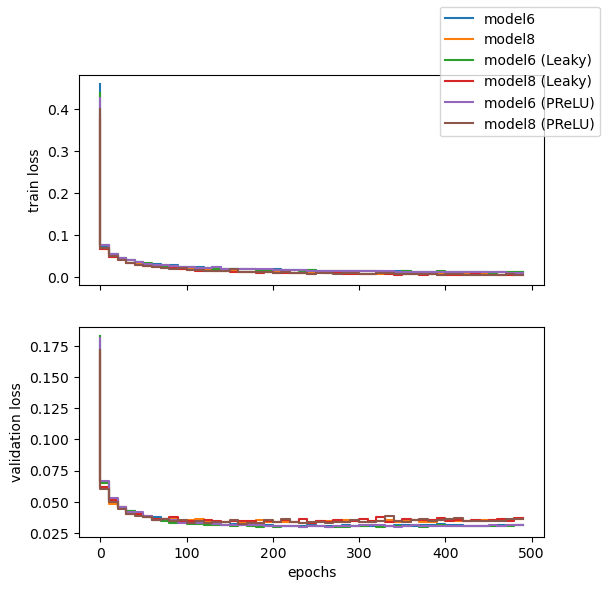

In [82]:
## Visualize the losses
xs = list(range(0, 500, 10))

fig, (ax1, ax2) = plt.subplots(2, figsize=(6, 6), sharex=True)

# model 6
ax1.step(xs, train_val_losses_lrs[0]["train"], label="model6")
ax2.step(xs, train_val_losses_lrs[0]["val"], label="model6")

# model 8
ax1.step(xs, train_val_losses_lrs[1]["train"], label="model8")
ax2.step(xs, train_val_losses_lrs[1]["val"], label="model8")


# model 6 LeakyReLU
ax1.step(xs, train_val_losses_lrs[2]["train"], label="model6 (Leaky)")
ax2.step(xs, train_val_losses_lrs[2]["val"], label="model6 (Leaky)")


# model 8 LeakyReLU
ax1.step(xs, train_val_losses_lrs[3]["train"], label="model8 (Leaky)")
ax2.step(xs, train_val_losses_lrs[3]["val"], label="model8 (Leaky)")


# model 6 PReLU
ax1.step(xs, train_val_losses_lrs[4]["train"], label="model6 (PReLU)")
ax2.step(xs, train_val_losses_lrs[4]["val"], label="model6 (PReLU)")


# model 8 PreLU
ax1.step(xs, train_val_losses_lrs[5]["train"], label="model8 (PReLU)")
ax2.step(xs, train_val_losses_lrs[5]["val"], label="model8 (PReLU)")

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")

ax1.set_ylabel("train loss")
ax2.set_ylabel("validation loss")
ax2.set_xlabel("epochs")

plt.savefig("lr1e-4.png", dpi=350)


### Training config: #2 (learning rate = 0.00001)

In [36]:
# training with a smaller learing rate

models_lrxs = [model.apply(init_weights) for model in models]
train_models_lrxs = []
train_val_losses_lrxs = []
for i, m in enumerate(models_lrxs):
    print(i, "--", "#" * 100)
    trained_model, losses = train(m, X_train, X_val, num_epochs=500, learning_rate=1e-5)
    train_models_lrxs.append(trained_model)
    train_val_losses_lrxs.append(losses)


0 -- ####################################################################################################
epoch	train_loss	val_loss
0	1.0168	0.7742
10	0.2008	0.1712
20	0.1550	0.1364
30	0.1239	0.1094
40	0.1088	0.0948
50	0.0983	0.0852
60	0.0903	0.0776
70	0.0843	0.0747
80	0.0794	0.0690
90	0.0753	0.0678
100	0.0717	0.0649
110	0.0684	0.0630
120	0.0655	0.0601
130	0.0629	0.0582
140	0.0605	0.0559
150	0.0583	0.0553
160	0.0563	0.0541
170	0.0546	0.0528
180	0.0530	0.0512
190	0.0515	0.0507
200	0.0502	0.0497
210	0.0490	0.0492
220	0.0479	0.0473
230	0.0469	0.0481
240	0.0459	0.0457
250	0.0451	0.0455
260	0.0442	0.0452
270	0.0434	0.0441
280	0.0427	0.0438
290	0.0420	0.0439
300	0.0413	0.0434
310	0.0406	0.0425
320	0.0400	0.0418
330	0.0394	0.0416
340	0.0388	0.0410
350	0.0383	0.0410
360	0.0377	0.0402
370	0.0372	0.0402
380	0.0368	0.0400
390	0.0363	0.0402
400	0.0359	0.0391
410	0.0354	0.0385
420	0.0350	0.0392
430	0.0346	0.0378
440	0.0342	0.0378
450	0.0339	0.0373
460	0.0335	0.0374
470	0.0332	0.0374
480	0.0328	0.03

NameError: name 'train_val_losses_lrxs' is not defined

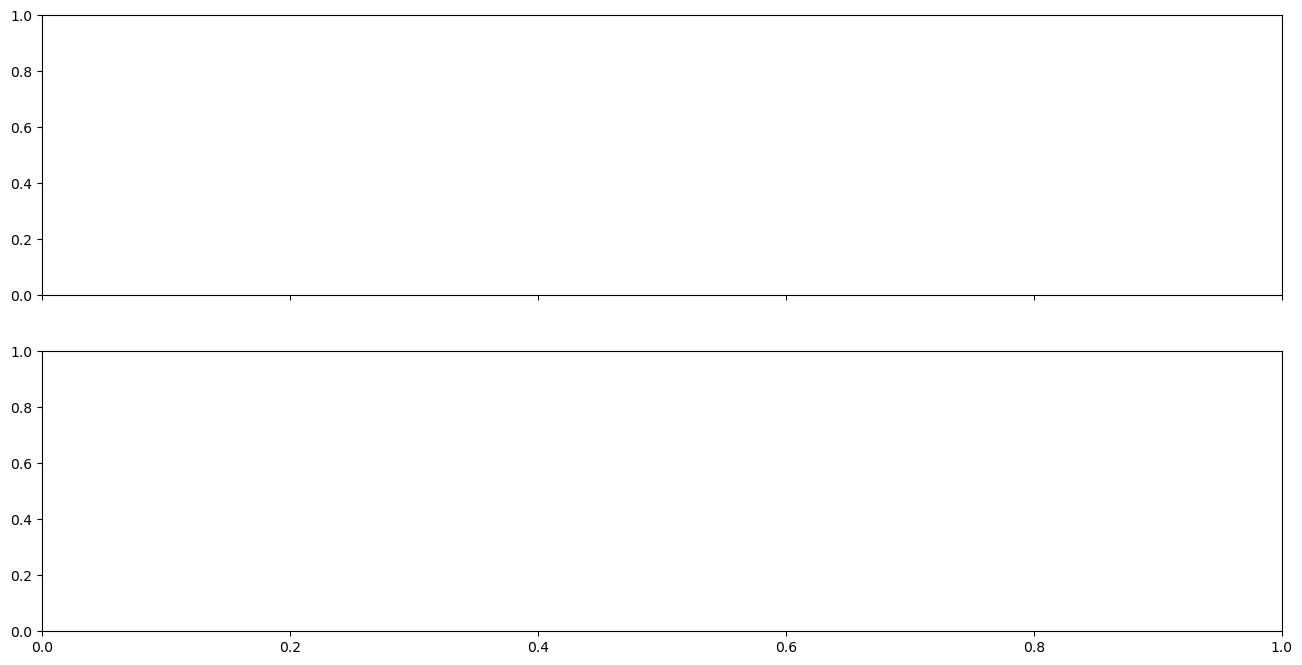

In [34]:
## Visualize the losses
xs = list(range(0, 500, 10))

fig, (ax1, ax2) = plt.subplots(2, figsize=(6, 6), sharex=True)

# model 6
ax1.step(xs, train_val_losses_lrxs[0]["train"], label="model6")
ax2.step(xs, train_val_losses_lrxs[0]["val"], label="model6")

# model 8
ax1.step(xs, train_val_losses_lrxs[1]["train"], label="model8")
ax2.step(xs, train_val_losses_lrxs[1]["val"], label="model8")


# model 6 LeakyReLU
ax1.step(xs, train_val_losses_lrxs[2]["train"], label="model6 (Leaky)")
ax2.step(xs, train_val_losses_lrxs[2]["val"], label="model6 (Leaky)")


# model 8 LeakyReLU
ax1.step(xs, train_val_losses_lrxs[3]["train"], label="model8 (Leaky)")
ax2.step(xs, train_val_losses_lrxs[3]["val"], label="model8 (Leaky)")


# model 6 PReLU
ax1.step(xs, train_val_losses_lrxs[4]["train"], label="model6 (PReLU)")
ax2.step(xs, train_val_losses_lrxs[4]["val"], label="model6 (PReLU)")


# model 8 PreLU
ax1.step(xs, train_val_losses_lrxs[5]["train"], label="model8 (PReLU)")
ax2.step(xs, train_val_losses_lrxs[5]["val"], label="model8 (PReLU)")

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")

ax1.set_ylabel("train loss")
ax2.set_ylabel("validation loss")
ax2.set_xlabel("epochs")

plt.savefig("lr1e-5.png", dpi=350)


In [116]:
# for i, m in enumerate(models_lrxs):
#     print(i, "--", "#"*100)
#     trained_model, losses = train(m, X_train, X_val, num_epochs=500, learning_rate=1e-5)
#     train_models_lrxs.append(trained_model)
#     train_val_losses_lrxs.append(losses)


0 -- ####################################################################################################
epoch	train_loss	val_loss
0	0.0325	0.0362
10	0.0322	0.0357
20	0.0319	0.0357
30	0.0316	0.0357
40	0.0313	0.0354
50	0.0310	0.0349
60	0.0307	0.0349
70	0.0305	0.0352
80	0.0302	0.0347
90	0.0300	0.0344
100	0.0297	0.0347
110	0.0295	0.0345
120	0.0293	0.0339
130	0.0291	0.0338
140	0.0288	0.0338
150	0.0286	0.0339
160	0.0284	0.0338
170	0.0282	0.0340
180	0.0280	0.0331
190	0.0278	0.0333
200	0.0276	0.0329
210	0.0275	0.0334
220	0.0273	0.0334
230	0.0271	0.0323
240	0.0269	0.0325
250	0.0268	0.0324
260	0.0266	0.0322
270	0.0264	0.0321
280	0.0263	0.0319
290	0.0261	0.0322
300	0.0260	0.0319
310	0.0258	0.0318
320	0.0257	0.0326
330	0.0255	0.0319
340	0.0254	0.0321
350	0.0253	0.0315
360	0.0251	0.0322
370	0.0250	0.0319
380	0.0249	0.0312
390	0.0248	0.0316
400	0.0246	0.0317
410	0.0245	0.0310
420	0.0244	0.0314
430	0.0243	0.0312
440	0.0242	0.0307
450	0.0241	0.0314
460	0.0240	0.0309
470	0.0239	0.0316
480	0.0238	0.03

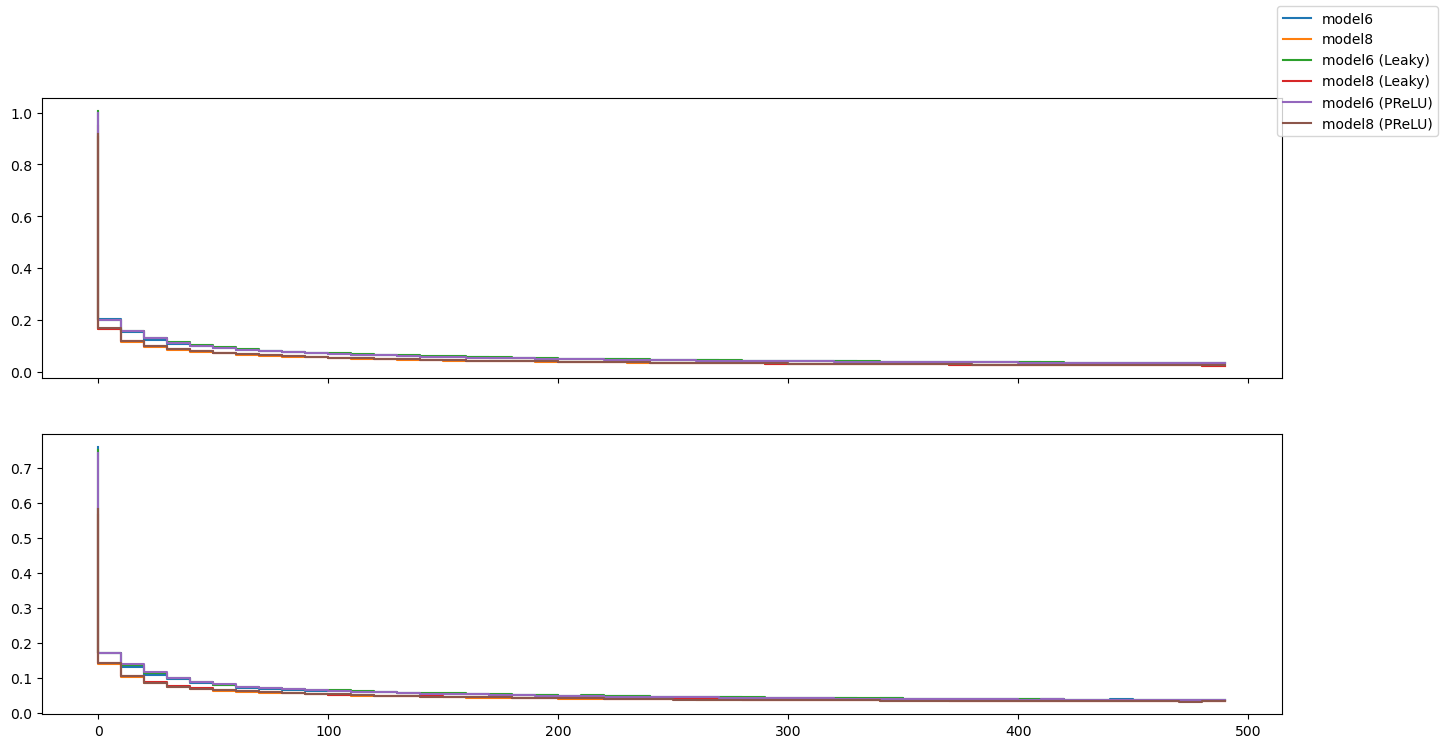

In [117]:
# ## Visualize the losses
# xs = list(range(0,500, 10))

# fig, (ax1, ax2) = plt.subplots(2, figsize=(16,8), sharex=True)

# # model 6
# ax1.step(xs, train_val_losses_lrxs[0]["train"], label="model6")
# ax2.step(xs, train_val_losses_lrxs[0]["val"], label="model6")

# # model 8
# ax1.step(xs, train_val_losses_lrxs[1]["train"], label="model8")
# ax2.step(xs, train_val_losses_lrxs[1]["val"], label="model8")


# # model 6 LeakyReLU
# ax1.step(xs, train_val_losses_lrxs[2]["train"], label="model6 (Leaky)")
# ax2.step(xs, train_val_losses_lrxs[2]["val"], label="model6 (Leaky)")


# # model 8 LeakyReLU
# ax1.step(xs, train_val_losses_lrxs[3]["train"], label="model8 (Leaky)")
# ax2.step(xs, train_val_losses_lrxs[3]["val"], label="model8 (Leaky)")


# # model 6 PReLU
# ax1.step(xs, train_val_losses_lrxs[4]["train"], label="model6 (PReLU)")
# ax2.step(xs, train_val_losses_lrxs[4]["val"], label="model6 (PReLU)")


# # model 8 PreLU
# ax1.step(xs, train_val_losses_lrxs[5]["train"], label="model8 (PReLU)")
# ax2.step(xs, train_val_losses_lrxs[5]["val"], label="model8 (PReLU)")

# handles, labels = ax1.get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper right')


## Training 12 layer model

In [6]:
model12 = model.AE12(1343, 50)
model12_leaky = model.LeakyAE12(1343, 50)
model12_param = model.ParamAE12(1343, 50)

deep_models = [model12, model12_leaky, model12_param]


In [7]:
model12_param


ParamAE12(
  (encoder): Sequential(
    (0): Linear(in_features=1343, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): PReLU(num_parameters=1)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): PReLU(num_parameters=1)
    (10): Linear(in_features=64, out_features=50, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=50, out_features=64, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=256, out_features=512, bias=True)
    (7): PReLU(num_parameters=1)
    (8): Linear(in_f

In [8]:
train_deep_models = []
train_val_loss_deep = []
for i, m in enumerate(deep_models):
    print(i, "--", "#" * 100)
    trained_model, losses = train(m, X_train, X_val, num_epochs=500, learning_rate=1e-4)
    train_deep_models.append(trained_model)
    train_val_loss_deep.append(losses)


0 -- ####################################################################################################
epoch	train_loss	val_loss
0	0.5797	0.1891
10	0.1847	0.1523
20	0.1380	0.1196
30	0.1169	0.1028
40	0.1056	0.0979
50	0.0975	0.0852
60	0.0913	0.0826
70	0.0834	0.0783
80	0.0776	0.0765
90	0.0730	0.0759
100	0.0683	0.0738
110	0.0649	0.0746
120	0.0612	0.0721
130	0.0580	0.0726
140	0.0608	0.0740
150	0.0522	0.0710
160	0.0506	0.0709
170	0.0467	0.0711
180	0.0452	0.0704
190	0.0429	0.0771
200	0.0402	0.0721
210	0.0409	0.0732
220	0.0393	0.0744
230	0.0357	0.0787
240	0.0343	0.0789
250	0.0328	0.0765
260	0.0309	0.0777
270	0.0310	0.0779
280	0.0301	0.0781
290	0.0286	0.0787
300	0.0261	0.0791
310	0.0276	0.0782
320	0.0255	0.0842
330	0.0233	0.0810
340	0.0228	0.0820
350	0.0234	0.0817
360	0.0213	0.0811
370	0.0257	0.0810
380	0.0197	0.0825
390	0.0190	0.0820
400	0.0189	0.0829
410	0.0195	0.0848
420	0.0182	0.0833
430	0.0181	0.0825
440	0.0162	0.0815
450	0.0155	0.0835
460	0.0190	0.0866
470	0.0158	0.0847
480	0.0160	0.08

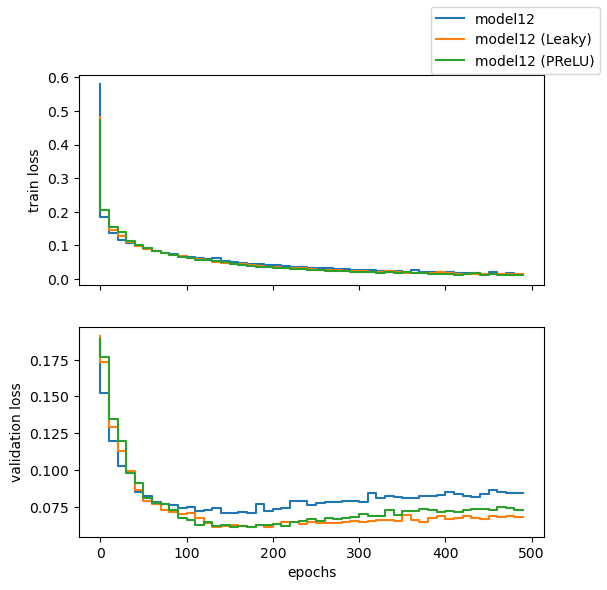

In [20]:
## Visualize the losses
xs = list(range(0, 500, 10))

fig, (ax1, ax2) = plt.subplots(2, figsize=(6, 6), sharex=True)

# model 6
ax1.step(xs, train_val_loss_deep[0]["train"], label="model12")
ax2.step(xs, train_val_loss_deep[0]["val"], label="model12")

# model 8
ax1.step(xs, train_val_loss_deep[1]["train"], label="model12 (Leaky)")
ax2.step(xs, train_val_loss_deep[1]["val"], label="model12 (Leaky)")


# model 6 LeakyReLU
ax1.step(xs, train_val_loss_deep[2]["train"], label="model12 (PReLU)")
ax2.step(xs, train_val_loss_deep[2]["val"], label="model12 (PReLU)")


handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")

ax1.set_ylabel("train loss")
ax2.set_ylabel("validation loss")
ax2.set_xlabel("epochs")

plt.savefig("12_layer_lr1e-4.png", dpi=350)


# Evaluation of models 

In [14]:
class torch_PCA:
    def __init__(self, n_comp=50):
        self.n_comp = n_comp
        self.mean = None
        self.cov = None
        self.components = None

    def fit(self, X):
        self.mean = X.mean(axis=0)
        # calculate the covariance matrix
        X = X - self.mean
        # transpose as the covariance function expects the samples as columns
        self.cov = torch.cov(X.T)
        # calculate the eigen values and-vectors
        eigenvalues, eigenvectors = torch.linalg.eig(self.cov)
        # transpose the vectors back (samples rows and columns features)
        eigenvectors = eigenvectors.T
        # sort the eigen -values and -vectors in reverse order (i.e. the order of importance)
        idxs = torch.argsort(torch.real(eigenvalues))
        idxs = torch.flip(idxs, dims=(0,))
        eigenvalues = eigenvalues[idxs]
        eigenvectors = eigenvectors[idxs]

        self.components = torch.real(eigenvectors[: self.n_comp])

    def transform(self, X):
        X = X - self.mean
        return X @ self.components.T


def pearson_cc(input1, input2):
    x, y = torch.flatten(input1), torch.flatten(input2)
    corr = torch.corrcoef(torch.stack((x, y)))
    return corr[0, 1].item()


def em(input1, input2):
    diff = torch.square(input1 - input2)
    sum_diff = torch.sqrt(diff.sum())
    return sum_diff.item()


def mae(input1, input2):
    criterion = nn.L1Loss()
    loss = criterion(input1, input2)
    return loss.item()


# test loop
@torch.no_grad()
def test(model, train_data, test_data, batch_size=1024):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Convert data to PyTorch tensors
    test_tensor = torch.Tensor(test_data).to(device)
    test_loader = DataLoader(test_tensor, batch_size=batch_size, shuffle=True)
    train_tensor = torch.Tensor(train_data).to(device)

    # instantiate torch_PCA
    pca_test = torch_PCA(n_comp=50)
    pca_train = torch_PCA(n_comp=50)
    # fit pca on train data
    pca_train.fit(train_tensor)

    # number of batch in test_loader
    n_batch = len(test_loader)
    stats = defaultdict(list)

    # loss functions
    functions = [pearson_cc, em, mae]
    model_losses = []
    pca_train_losses = []
    pca_test_losses = []

    for i, batch in enumerate(test_loader):
        print(f"[{i+1}/{n_batch}]")
        # model loss
        outputs = model(batch)
        # Reconstruction loss
        model_loss = [func(outputs, batch) for func in functions]
        stats["model"].append(model_loss)

        # pca fitted on training data
        train_transform = pca_train.transform(batch)
        train_reconstruct = (train_transform @ pca_train.components) + pca_train.mean
        pca_train_loss = [func(train_reconstruct, batch) for func in functions]
        stats["pca_train"].append(pca_train_loss)

        # pca fitted on test
        pca_test.fit(batch)
        test_transform = pca_test.transform(batch)
        test_rec = (test_transform @ pca_test.components) + pca_test.mean
        pca_test_loss = [func(test_rec, batch) for func in functions]
        stats["pca_test"].append(pca_test_loss)
    return stats


In [15]:
test_names = ["PCC", "EM", "MAE"]
model_names = [
    "model6",
    "model8",
    "model6_leaky",
    "model8_leaky",
    "model6_prelu",
    "model8_prelu",
]
# np.array.mean(axis=0) en np.array.mean(stdev)


### evaluation at lr=1e-3

In [31]:
initial_test_of_test_function = []
for i, m in enumerate(train_models):
    print(i, "--", "#" * 100)
    stats = test(m, X_train, X_test)
    initial_test_of_test_function.append(stats)


0 -- ####################################################################################################
[1/33]
[2/33]
[3/33]
[4/33]
[5/33]
[6/33]
[7/33]
[8/33]
[9/33]
[10/33]
[11/33]
[12/33]
[13/33]
[14/33]
[15/33]
[16/33]
[17/33]
[18/33]
[19/33]
[20/33]
[21/33]
[22/33]
[23/33]
[24/33]
[25/33]
[26/33]
[27/33]
[28/33]
[29/33]
[30/33]
[31/33]
[32/33]
[33/33]
1 -- ####################################################################################################
[1/33]
[2/33]
[3/33]
[4/33]
[5/33]
[6/33]
[7/33]
[8/33]
[9/33]
[10/33]
[11/33]
[12/33]
[13/33]
[14/33]
[15/33]
[16/33]
[17/33]
[18/33]
[19/33]
[20/33]
[21/33]
[22/33]
[23/33]
[24/33]
[25/33]
[26/33]
[27/33]
[28/33]
[29/33]
[30/33]
[31/33]
[32/33]
[33/33]
2 -- ####################################################################################################
[1/33]
[2/33]
[3/33]
[4/33]
[5/33]
[6/33]
[7/33]
[8/33]
[9/33]
[10/33]
[11/33]
[12/33]
[13/33]
[14/33]
[15/33]
[16/33]
[17/33]
[18/33]
[19/33]
[20/33]
[21/33]
[22/33]
[23/3

In [16]:
def summary_scores(model_stats):
    model, pca_train, pca_test = [], [], []
    for test_scores in model_stats:
        for key, val in test_scores.items():
            arr = np.array(val)
            means = arr.mean(axis=0)
            std = np.std(arr, axis=0)
            if key == "model":
                model.append((means, std))
            elif key == "pca_train":
                pca_train.append((means, std))
            elif key == "pca_test":
                pca_test.append((means, std))
            else:
                assert ValueError("Somethings is wrong in the code")
    model_means = np.stack([x[0] for x in model])
    model_std = np.stack([x[1] for x in model])
    pca_train_mean = np.stack([x[0] for x in pca_train])
    pca_train_std = np.stack([x[1] for x in pca_train])
    pca_test_mean = np.stack([x[0] for x in pca_test])
    pca_test_std = np.stack([x[1] for x in pca_test])
    return (
        (model_means, model_std),
        (pca_train_mean, pca_train_std),
        (pca_test_mean, pca_test_std),
    )


In [49]:
init_test_model_score, init_test_pca_train_score, init_test_pca_test_score = (
    summary_scores(initial_test_of_test_function)
)


In [25]:
def md(matrix):
    df = pd.DataFrame(matrix.round(3), index=model_names, columns=test_names)
    print(df.to_markdown())


In [87]:
init_test_model_score


(array([[9.79438141e-01, 2.34925401e+02, 9.98626430e-02],
        [9.77151864e-01, 2.47510286e+02, 1.04951971e-01],
        [9.79765211e-01, 2.33313161e+02, 9.95245081e-02],
        [9.76634871e-01, 2.50580252e+02, 1.06281196e-01],
        [9.79460263e-01, 2.34877524e+02, 1.01523981e-01],
        [9.77011973e-01, 2.48123266e+02, 1.04983641e-01]]),
 array([[1.80879782e-03, 1.15075583e+01, 3.93054014e-03],
        [1.85827471e-03, 1.24499469e+01, 4.03167924e-03],
        [1.90429613e-03, 1.33099171e+01, 3.34685512e-03],
        [2.31999586e-03, 1.35706444e+01, 3.40868645e-03],
        [1.99160251e-03, 1.18766306e+01, 3.04256338e-03],
        [2.25786774e-03, 1.00294897e+01, 3.00696144e-03]]))

### evaluation at lr=1e-4



In [17]:
def test_models(models):
    initial_test_of_test_function = []
    for i, m in enumerate(models):
        print(i, "--", "#" * 100)
        stats = test(m, X_train, X_test)
        initial_test_of_test_function.append(stats)
    return initial_test_of_test_function


In [75]:
models_lrs_test = test_models(models_lrs)


0 -- ####################################################################################################
[1/33]
[2/33]
[3/33]
[4/33]
[5/33]
[6/33]
[7/33]
[8/33]
[9/33]
[10/33]
[11/33]
[12/33]
[13/33]
[14/33]
[15/33]
[16/33]
[17/33]
[18/33]
[19/33]
[20/33]
[21/33]
[22/33]
[23/33]
[24/33]
[25/33]
[26/33]
[27/33]
[28/33]
[29/33]
[30/33]
[31/33]
[32/33]
[33/33]
1 -- ####################################################################################################
[1/33]
[2/33]
[3/33]
[4/33]
[5/33]
[6/33]
[7/33]
[8/33]
[9/33]
[10/33]
[11/33]
[12/33]
[13/33]
[14/33]
[15/33]
[16/33]
[17/33]
[18/33]
[19/33]
[20/33]
[21/33]
[22/33]
[23/33]
[24/33]
[25/33]
[26/33]
[27/33]
[28/33]
[29/33]
[30/33]
[31/33]
[32/33]
[33/33]
2 -- ####################################################################################################
[1/33]
[2/33]
[3/33]
[4/33]
[5/33]
[6/33]
[7/33]
[8/33]
[9/33]
[10/33]
[11/33]
[12/33]
[13/33]
[14/33]
[15/33]
[16/33]
[17/33]
[18/33]
[19/33]
[20/33]
[21/33]
[22/33]
[23/3

In [76]:
lrs_model, lrs_pca_train, lrs_test = summary_scores(models_lrs_test)


### evaluation at lr=1e-5


In [98]:
models_lrxs_test = test_models(models_lrxs)
lrxs_model, lrxs_pca_train, lrxs_pca_test = test_models(models_lrxs_test)


0 -- ####################################################################################################
[1/33]
[2/33]
[3/33]
[4/33]
[5/33]
[6/33]
[7/33]
[8/33]
[9/33]
[10/33]
[11/33]
[12/33]
[13/33]
[14/33]
[15/33]
[16/33]
[17/33]
[18/33]
[19/33]
[20/33]
[21/33]
[22/33]
[23/33]
[24/33]
[25/33]
[26/33]
[27/33]
[28/33]
[29/33]
[30/33]
[31/33]
[32/33]
[33/33]
1 -- ####################################################################################################
[1/33]
[2/33]
[3/33]
[4/33]
[5/33]
[6/33]
[7/33]
[8/33]
[9/33]
[10/33]
[11/33]
[12/33]
[13/33]
[14/33]
[15/33]
[16/33]
[17/33]
[18/33]
[19/33]
[20/33]
[21/33]
[22/33]
[23/33]
[24/33]
[25/33]
[26/33]
[27/33]
[28/33]
[29/33]
[30/33]
[31/33]
[32/33]
[33/33]
2 -- ####################################################################################################
[1/33]
[2/33]
[3/33]
[4/33]
[5/33]
[6/33]
[7/33]
[8/33]
[9/33]
[10/33]
[11/33]
[12/33]
[13/33]
[14/33]
[15/33]
[16/33]
[17/33]
[18/33]
[19/33]
[20/33]
[21/33]
[22/33]
[23/3

AttributeError: 'collections.defaultdict' object has no attribute 'to'

### Evaluation of 12 layer models


In [18]:
deep_models_test = test_models(train_deep_models)


0 -- ####################################################################################################
[1/33]
[2/33]
[3/33]
[4/33]
[5/33]
[6/33]
[7/33]
[8/33]
[9/33]
[10/33]
[11/33]
[12/33]
[13/33]
[14/33]
[15/33]
[16/33]
[17/33]
[18/33]
[19/33]
[20/33]
[21/33]
[22/33]
[23/33]
[24/33]
[25/33]
[26/33]
[27/33]
[28/33]
[29/33]
[30/33]
[31/33]
[32/33]
[33/33]
1 -- ####################################################################################################
[1/33]
[2/33]
[3/33]
[4/33]
[5/33]
[6/33]
[7/33]
[8/33]
[9/33]
[10/33]
[11/33]
[12/33]
[13/33]
[14/33]
[15/33]
[16/33]
[17/33]
[18/33]
[19/33]
[20/33]
[21/33]
[22/33]
[23/33]
[24/33]
[25/33]
[26/33]
[27/33]
[28/33]
[29/33]
[30/33]
[31/33]
[32/33]
[33/33]
2 -- ####################################################################################################
[1/33]
[2/33]
[3/33]
[4/33]
[5/33]
[6/33]
[7/33]
[8/33]
[9/33]
[10/33]
[11/33]
[12/33]
[13/33]
[14/33]
[15/33]
[16/33]
[17/33]
[18/33]
[19/33]
[20/33]
[21/33]
[22/33]
[23/3

In [22]:
score_model_deep, _, _ = summary_scores(deep_models_test)


In [30]:
df = pd.DataFrame(
    score_model_deep[0],
    columns=test_names,
    index=["model12", "model12_leaky", "model12_prelu"],
)


In [32]:
print(df.to_markdown())


|               |      PCC |      EM |      MAE |
|:--------------|---------:|--------:|---------:|
| model12       | 0.947357 | 374.311 | 0.156151 |
| model12_leaky | 0.957275 | 336.905 | 0.139318 |
| model12_prelu | 0.955456 | 344.028 | 0.144214 |


### scores using 1343 samples

In [ ]:
# 12 layer model
pd.DataFrame.from_dict(model12_test, orient="index", columns=["PCC", "EM", "MAE"])


In [ ]:
# 6 layer model
pd.DataFrame.from_dict(model6_stats, orient="index", columns=["PCC", "EM", "MAE"])


### scores on all the data 

In [ ]:
%%time
import dask.dataframe as dd
file = "/lustre/BIF/nobackup/almen002/gene_FPKM_200501.csv"

exp = pd.read_csv(file, header=0, index_col=0, engine="pyarrow")


In [34]:
scaler = StandardScaler()
scaled_exp = scaler.fit_transform(exp.T)
X_train, X_test = train_test_split(
    scaled_exp, test_size=0.9, shuffle=True, random_state=RANDOM
)
X_train, X_val = train_test_split(
    X_train, test_size=0.1, shuffle=True, random_state=RANDOM
)


In [ ]:
exp.shape


In [43]:
model6_full = model.AE6(exp.shape[0], 50)


In [ ]:
model6_full_train = train(model6_full, X_train, X_test, num_epochs=500)


In [ ]:
model12_full = model.AE12(exp.shape[0], 50)
model12_full_train = train(model12_full, X_train, X_test, num_epochs=500)


In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, figsize=(18, 6), sharex=True)

ax1.plot(losses["train"])
ax1.set_ylabel("training loss")

ax2.plot(losses["val"])
ax2.set_ylabel("validation loss")

ax3.plot(losses["test"])
ax3.set_ylabel("test loss")

ax4.plot(losses["pca"])
ax4.set_ylabel("pca loss")

ax5.plot([x - y for x, y in zip(losses["test"], losses["pca"])])
ax5.set_ylabel("test - pca")


ax5.set_xlabel("epochs")
